传统的协同过滤推荐系统一般基于是用户对商品的评分(如5星好评)，这些评分通常可以明确表达用户对商品的喜好,通过分析用户评分，协同过滤推荐算法可以为用户推荐他们可能喜好的其他商品。但是要收集用户评分有时候会非常的困难,大多数情况是我们无法收集到用户的评分，那如果没有用户评分我们还能开发推荐系统吗？其实也是可以的，除了“显示”的用户评分，还有一种“隐式”的用户对物品喜好的表达方式，如用户的点击，点赞，浏览，收藏，评论等行为，隐式的表达方式虽然没有显示的表达方式那样直接表达用户的喜好，但它也可以间接反映出用户对物品的喜好程度。今天我们就来尝试利用用户隐式偏好数据,如点击，点赞，浏览，收藏，评论等行为数据，同时使用python和implicit库来开发一个个性化的推荐系统。

# 数据

我们的数据来自于kaggle,你可以在这里下载，这里包含了两个数据文件(shared_articles.csv，users_interactions.csv)，请大家将它们下载下来，这些数据来自于Deskdrop是 CI＆T开发的内部通信平台,该平台还允许公司员工与同行分享相关文章，并围绕他们进行协作。数据包中含大约73,000个用户在平台上共享的3k多篇公共文章上的交互信息，更重要的是，它包含丰富的隐式反馈信息，记录了不同的交互类型，我们可以利用这些信息来推断用户对文章的兴趣程度。

同时我们将会使用implicit库，它是基于隐式偏好数据的python快速协同过滤推荐算法,它主要通过矩阵分解的方法来预测用户对物品的评分，从而进行个性化的推荐。

我们首先加载数据集：

In [1]:
import pandas as pd
import scipy.sparse as sparse
import numpy as np
import random
import implicit
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

In [2]:
articles_df = pd.read_csv('./data/shared_articles.csv')
interactions_df = pd.read_csv('./data/users_interactions.csv')
articles_df.drop(['authorUserAgent', 'authorRegion', 'authorCountry'], axis=1, inplace=True)
interactions_df.drop(['userAgent', 'userRegion', 'userCountry'], axis=1, inplace=True)
articles_df = articles_df.drop_duplicates()
interactions_df = interactions_df.drop_duplicates()
print("在shared_articles表的contentId 列中总共有 %d 个唯一值." % articles_df['contentId'].nunique())
print("在users_interactions表的personId 列中总共有 %d 个唯一值." % interactions_df['personId'].nunique())
articles_df.head()

在shared_articles表的contentId 列中总共有 3057 个唯一值.
在users_interactions表的personId 列中总共有 1895 个唯一值.


,timestamp,eventType,contentId,authorPersonId,authorSessionId,contentType,url,title,text,lang
0,1459192779,CONTENT REMOVED,-6451309518266745024,4340306774493623681,8940341205206233829,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


In [3]:
interactions_df.head()

,timestamp,eventType,contentId,personId,sessionId
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714


In [4]:
articles_df['eventType'].value_counts()

CONTENT SHARED     3047
CONTENT REMOVED      75
Name: eventType, dtype: int64

In [5]:
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']
articles_df.drop('eventType', axis=1, inplace=True)

In [6]:
articles_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3047 entries, 1 to 3121
Data columns (total 9 columns):
timestamp          3047 non-null int64
contentId          3047 non-null int64
authorPersonId     3047 non-null int64
authorSessionId    3047 non-null int64
contentType        3047 non-null object
url                3047 non-null object
title              3047 non-null object
text               3047 non-null object
lang               3047 non-null object
dtypes: int64(4), object(5)
memory usage: 238.0+ KB


In [7]:
interactions_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70028 entries, 0 to 72311
Data columns (total 5 columns):
timestamp    70028 non-null int64
eventType    70028 non-null object
contentId    70028 non-null int64
personId     70028 non-null int64
sessionId    70028 non-null int64
dtypes: int64(4), object(1)
memory usage: 3.2+ MB


# 数据预处理 

 接下来我们要对shared_articles.csv和users_interactions.csv中的数据进行整理，并删除一些不需要的列,并将两个表进行合并

In [8]:
df = pd.merge(interactions_df[['contentId','personId', 'eventType']], articles_df[['contentId', 'title']], how = 'inner', on = 'contentId')
df.head()

,contentId,personId,eventType,title
0,-3499919498720038879,-8845298781299428018,VIEW,Hiri wants to fix the workplace email problem
1,-3499919498720038879,-8845298781299428018,VIEW,Hiri wants to fix the workplace email problem
2,-3499919498720038879,-108842214936804958,VIEW,Hiri wants to fix the workplace email problem
3,-3499919498720038879,-1443636648652872475,VIEW,Hiri wants to fix the workplace email problem
4,-3499919498720038879,-1443636648652872475,VIEW,Hiri wants to fix the workplace email problem


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69985 entries, 0 to 69984
Data columns (total 4 columns):
contentId    69985 non-null int64
personId     69985 non-null int64
eventType    69985 non-null object
title        69985 non-null object
dtypes: int64(2), object(2)
memory usage: 2.7+ MB


"eventType"字段记录了用户行为的类别，因此我们需要查看一下用户行为的分类情况：

In [10]:
df['eventType'].value_counts()

VIEW               58759
LIKE                5745
BOOKMARK            2463
COMMENT CREATED     1611
FOLLOW              1407
Name: eventType, dtype: int64

我们看到存在以下5种用户行为分类:

* VIEW: 查看，表示用户点击过该篇文章
* LIKE:  点赞，表示用户喜好该篇文章。
* BOOKMARK: 加入书签，用户已将该文章加入书签，以便将来查看。这是用户对该文章表现出感兴趣的迹象
* COMMENT CREATED: 创建评论，说明用户被这篇文章所吸引，同时希望表达自己的观点。
* FOLLOW: 关注，用户关注了文章的作者，这应该说明用户对这位作者的文章非常感兴趣  

我们可以认为上述的5种用户行为可以表达出用户对文章的不同的喜好程度，为此我们可以为这5种用户行为各打上一个分值，以便量化用户的喜好程度:

In [11]:
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 3.0, 
   'FOLLOW': 4.0,
   'COMMENT CREATED': 5.0,  
}

df['eventStrength'] = df['eventType'].apply(lambda x: event_type_strength[x])
df.sample(10)

,contentId,personId,eventType,title,eventStrength
68299,2760335717049716507,-2726721797588771398,VIEW,"Razorfish, US digital revenues, drag down Publ...",1.0
10531,2602738827388230683,-1443636648652872475,VIEW,Apple is working on an AI system that wipes th...,1.0
34808,-5879360586463363298,7741213197781008422,VIEW,Introducing LambCI - a serverless build system,1.0
2511,5964888566269323942,4670267857749552625,VIEW,PwC faz virada digital e já fatura US$ 1 bilhã...,1.0
39484,-2447632164766022033,-3643155458357242906,VIEW,O que o GitHub tem a nos dizer sobre os estere...,1.0
54306,6031953227014493100,3007673865213720513,VIEW,O chefe é gay. E daí?,1.0
31294,-5014627593450767720,8271619811366074205,VIEW,Drupal and ambitious digital experiences,1.0
5329,-3581194288660477595,-1032019229384696495,LIKE,The End Of Apple Man,2.0
14908,880612740433495828,6013226412048763966,VIEW,O que você deve fazer para se tornar um líder ...,1.0
52071,3367026768872537336,-9223121837663643404,VIEW,Seja esperto no trabalho: Melhore a comunicaçã...,1.0


In [12]:
df = df.drop_duplicates()
grouped_df = df.groupby(['personId', 'contentId', 'title']).sum().reset_index()
grouped_df.sample(10)

,personId,contentId,title,eventStrength
1758,-8674958742744576254,-1452340812018195881,Globo G1 lança Bot para o Telegram que te ajud...,1.0
39138,8562738815734604501,-4625438649010928449,Top Asset Tracking Software: The 52 Best Tools...,1.0
26505,2754566407772265068,8582210754044680874,Reactive log stream processing with RxJava - P...,1.0
18400,-830175562779396891,-1178371721262103855,"Ultrapar, por meio da Ipiranga, assina compra ...",1.0
23205,1120069409160402054,-1897853393557630253,Your health insurance might score you an Apple...,1.0
16885,-1393866732742189886,7459643459148487877,Grupo de bancos adere à tecnologia do bitcoin ...,1.0
30406,3813842765808990208,5962268176939710955,"BigQuery 1.11, now with Standard SQL, IAM, and...",1.0
5312,-6874532444478397764,897043351348716074,Mark Zuckerberg compartilha como será o Facebo...,1.0
10020,-4028919343899978105,-912681925384819247,15 Interesting JavaScript and CSS Libraries fo...,3.0
15120,-1799631734242668035,-746073086109727488,How to get the most from your agency relations...,12.0


In [13]:
grouped_df.dtypes

personId           int64
contentId          int64
title             object
eventStrength    float64
dtype: object

personId和contentId都是int64的长整型字段，为了避免出现负整数警告信息以及为了节省内存空间，我们可以将他们转换成int16的短整型字段:

In [14]:
grouped_df['title'] = grouped_df['title'].astype("category")
grouped_df['personId'] = grouped_df['personId'].astype("category")
grouped_df['contentId'] = grouped_df['contentId'].astype("category")
grouped_df['person_id'] = grouped_df['personId'].cat.codes
grouped_df['content_id'] = grouped_df['contentId'].cat.codes
grouped_df.sample(10)

,personId,contentId,title,eventStrength,person_id,content_id
16568,-1443636648652872475,5314107418764884230,Deep learning software knows that a rose is a ...,10.0,798,2343
9002,-4447090897576014728,-4130193294870737688,Game of Loans,1.0,492,829
5544,-6786856227257648356,9042192299854648021,Google's cloud platform is now a force to be r...,1.0,245,2952
33662,5321535590192312132,-5813211845057621660,Communication patterns in a Microservice world,1.0,1488,558
1096,-8860671864164757449,3608243634452078989,Carne artificial acabará com o agronegócio bra...,1.0,29,2058
9329,-4298177694576275482,2301338403202434417,Top 10 GCP sessions from Google I/O 2016,1.0,509,1833
7095,-5706287032724665714,-4707863452603278075,PSA: iOS 9.3.5 fixes serious security exploit ...,1.0,348,741
14147,-2511855597392146401,-8909927294729358771,"Android N Developer Preview 2, out today! | An...",3.0,693,75
25494,2279740393166882579,-6810702648836067504,"diagramas para entender, criar, inovar e empre...",1.0,1182,401
29014,3609194402293569455,-3095494965842381869,"Fintechs can help incumbents, not just disrupt...",1.0,1319,998


In [15]:
grouped_df.dtypes

personId         category
contentId        category
title            category
eventStrength     float64
person_id           int16
content_id          int16
dtype: object

这样我们就可以不再需要personId和contentId这两个字段了。

# 交替最小二乘法（Alternating Least Squares）

在矩阵分解（matrix factorization）中使用的一种算法。有一个稀疏矩阵，假设这个矩阵是低阶的，可以分解成两个小矩阵相乘。然后交替对两个小矩阵使用最小二乘法，算出这两个小矩阵，就可以估算出稀疏矩阵缺失的值：

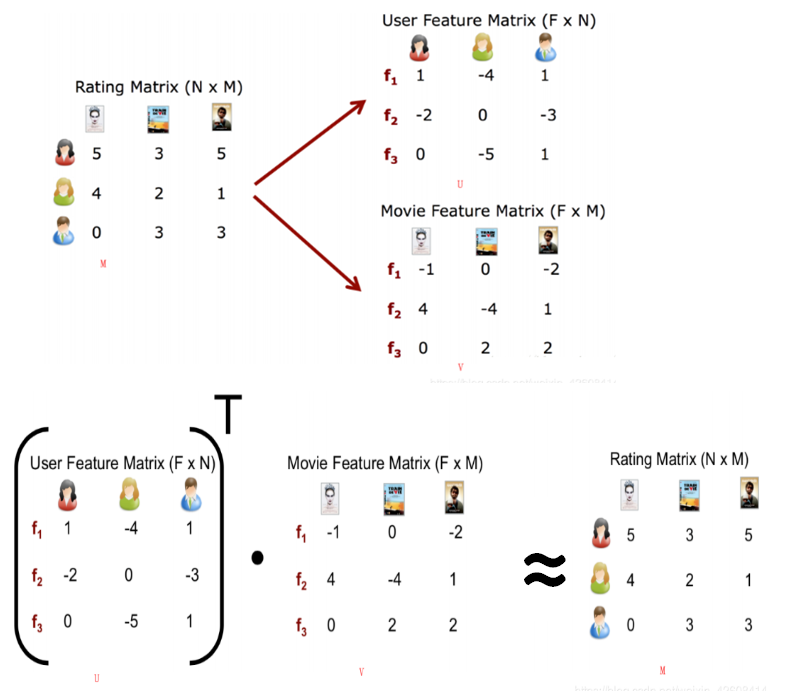

假设用户评分矩阵可以分解成两个矩阵相乘的形式,这两个矩阵相乘的结果就可以近似等于原来的矩阵，为了寻找出最优的两个矩阵以便它们相乘以后的结果与原来的矩阵误差最小，我们需要使用交替最小二乘法，算法在迭代的过程中交替固定两个矩阵中的一个矩阵然后使用最小二乘法求出另外一个矩阵的最优矩阵，最终使两个矩阵都是最优矩阵并且它们乘积的结果与原来的矩阵误差最小。


在这里我们将使用implicit库中的als.AlternatingLeastSquares方法来实现交替最小二乘法。不过，这里我们首先要创建两个稀疏矩阵:内容-人-评分矩阵，人-内容-评分矩阵。


In [16]:
sparse_content_person = sparse.csr_matrix((grouped_df['eventStrength'].astype(float), (grouped_df['content_id'], grouped_df['person_id'])))
sparse_person_content = sparse.csr_matrix((grouped_df['eventStrength'].astype(float), (grouped_df['person_id'], grouped_df['content_id'])))

print(sparse_content_person.shape)
print(sparse_person_content.shape)

(2979, 1895)
(1895, 2979)


我们看到文章总数为2979，用户总数为1895 

内容-人-评分矩阵(sparse_content_person)的每一行代表一篇文章，每一列代表一个用户。

人-内容-评分矩阵(sparse_person_content)的每一行代表一个用户，每一列代表一篇文章。

下面我们开始训练模型，并设置20个特征因子。

# 训练模型

下面我们开始训练模型，并设置20个特征因子。

In [17]:
alpha = 15
data = (sparse_content_person * alpha).astype('double')

model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=50)
model.fit(data)

100%|████████████████████████████████████████| 50.0/50 [00:01<00:00, 32.34it/s]


# 推荐内容相似的文章

模型训练完成以后，我们可以计算文章之间的相似度，并根据相似度来进行推荐:我们以content_id = 235的文章为例,这篇文章的标题是"Artificial intelligence is hard to see"，这是一篇有关人工智能的文章，我们的目标是在所有的文章的标题中找出和它最相似的10篇文章标题。这里我们主要通过计算文章之间的相似度，在计算相似度的过程中有以下几个步骤:

从模型中获取人和内容的向量
计算内容的向量的范数
计算相似度得分
获取相似度得分最大的10篇文章
生成这10篇文章的content_id和title的元组

In [18]:
content_id = 235
n_similar = 10
print(grouped_df.title.loc[grouped_df.content_id == content_id][0])

Artificial intelligence is hard to see


In [19]:
#获取用户矩阵
person_vecs = model.user_factors
#获取内容矩阵
content_vecs = model.item_factors
#计算内容的向量的范数
content_norms = np.sqrt((content_vecs * content_vecs).sum(axis=1))
#计算指定的content_id 与其他所有文章的相似度
scores = content_vecs.dot(content_vecs[content_id]) / content_norms
#获取相似度最大的10篇文章
top_idx = np.argpartition(scores, -n_similar)[-n_similar:]
#组成content_id和title的元组
similar = sorted(zip(top_idx, scores[top_idx] / content_norms[content_id]), key=lambda x: -x[1])

print(person_vecs.shape)
print(content_vecs.shape)

(1895, 20)
(2979, 20)


我们注意到我们的用户矩阵和我们的内容矩阵都只有20列，这是因为我们在定义模型时设置了factors=20。这里的用户矩阵和内容矩阵就类似与前面交替最小二乘法示意图中介绍的User Feature Matrix和Movie Feature Matrix.

下面我们展示这10篇最相似的文章title:

In [20]:
for content in similar:
    idx, score = content
    print(grouped_df.title.loc[grouped_df.content_id == idx].iloc[0],"|",score)

Artificial intelligence is hard to see | 1.0000001
Machine Learning Is No Longer Just for Experts | 0.75046736
Clarifying the uses of artificial intelligence in the enterprise | 0.7082239
Google Calendar for Android can now find meeting times that work for everyone | 0.6599234
Money 20/20 Panel: Artificial Intelligence and Machine Learning | 0.65292907
Leonardo Dicaprio, Barry Sternlicht back Qloo, a cultural recommendation engine | 0.6389775
A trip to Google's New York City Pop-Up Shop | 0.62346613
Stop Coding Machine Learning Algorithms From Scratch - Machine Learning Mastery | 0.6212184
Larry Page's dream of building a 'Google Island' could be coming true | 0.6211126
10 documentários para empreendedores | 0.617943


这些文章似乎都和人工智能有关。其中第一篇文章就是content_id = 235的文章本身，正如我们前面说content_id = 235要和所有文章计算相似度，这当然也包含它自己本身，所以content_id = 235的文章和自己的相似度应该是最大的，因此应该排第一位，其余9篇文章标题则是按照相似度由高到低排列的。

# 为用户推荐他可能感兴趣的文章

接下来我们要为用户推荐他们没有看过的(即没有发生过交互行为),但是他们可能会敢兴趣的文章。我们首先要定义一个推荐函数，在推荐函数中我们主要要做以下3件事:

* 将指定用户的用户向量乘以内容矩阵，得到该用户对所有文章的评分向量
* 从评分向量中过滤掉用户已经评分过的文章(将其评分值置为0),因为用户已经发生过交互行为的文章不应该被推荐
* 将余下的评分分数排序，并输出分数最大的10篇文章。

In [21]:
def recommend(person_id, sparse_person_content, person_vecs, content_vecs, num_contents=10):
    #*****************得到指定用户对所有文章的评分向量******************************
    # 将该用户向量乘以内容矩阵(做点积),得到该用户对所有文章的评价分数向量
    rec_vector = person_vecs[person_id,:].dot(content_vecs.T).toarray()
    
    #**********过滤掉用户已经评分过的文章(将其评分值置为0),因为用户已经发生过交互行为的文章不应该被推荐*******
    # 从稀疏矩阵sparse_person_content中获取指定用户对所有文章的评价分数
    person_interactions = sparse_person_content[person_id,:].toarray()
    # 为该用户的对所有文章的评价分数+1，那些没有被该用户看过(view)的文章的分数就会等于1(原来是0)
    person_interactions = person_interactions.reshape(-1) + 1
    # 将那些已经被该用户看过的文章的分数置为0
    person_interactions[person_interactions > 1] = 0        
    # 将该用户的评分向量做标准化处理,将其值缩放到0到1之间。
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
    # 过滤掉和该用户已经交互过的文章，这些文章的评分会和0相乘。
    recommend_vector = person_interactions * rec_vector_scaled
    
    #*************将余下的评分分数排序，并输出分数最大的10篇文章************************
    # 根据评分值进行排序,并获取指定数量的评分值最高的文章
    content_idx = np.argsort(recommend_vector)[::-1][:num_contents]
    
    # 定义两个list用于存储文章的title和推荐分数。
    titles = []
    scores = []

    for idx in content_idx:
        # 将title和分数添加到list中
        titles.append(grouped_df.title.loc[grouped_df.content_id == idx].iloc[0])
        scores.append(recommend_vector[idx])

    recommendations = pd.DataFrame({'title': titles, 'score': scores})

    return recommendations

在上面的函数中，我们首先从稀疏矩阵sparse_person_content中获取指定用户对所有文章的评分，这里需要注意一点的是，如果某个用户对某篇文章没有发生过交互行为(VIEW,LIKE,BOOKMARK,COMMENT CREATED,FOLLOW),那么在原始的数据集中是不存在这条交互记录的，但是当我们使用了稀疏矩阵的.toarray()方法后，那些用户没有发生过交互的所有文章都会被展示出来，只不过对那些文章的评分值都会被置为0，因此toarray()方法展现的是所有用户对所有文章的评分结果。

下面我们要为特定的用户推荐他们没有看过的，但可能会感兴趣的10篇文章：

In [22]:
# 从model中获取经过训练的用户和内容矩阵,并将它们存储为稀疏矩阵
person_vecs = sparse.csr_matrix(model.user_factors)
content_vecs = sparse.csr_matrix(model.item_factors)

# 为指定用户推荐文章。
person_id = 50
recommendations = recommend(person_id, sparse_person_content, person_vecs, content_vecs)
print(recommendations)

                                               title     score
0  Custo do Erro - Cinco motivos para investir em...  1.000000
1  Ray Kurzweil: The world isn't getting worse - ...  0.859316
2  How I built an app with 500,000 users in 5 day...  0.827874
3           Drupal and ambitious digital experiences  0.815111
4  Do You Suffer From Deployment Anxiety? - DZone...  0.812248
5  Former Google career coach shares a visual tri...  0.788370
6  'The Simpsons' celebrates 600 episodes with a ...  0.781911
7  GitLab launches Issue Boards, an open-source t...  0.768058
8                            15 minutos sobre Docker  0.757384
9  BDD Best Practices and Guidelines - Testing Ex...  0.753251


In [23]:
grouped_df.loc[grouped_df['person_id'] == 50].sort_values(by=['eventStrength'], 
                                                          ascending=False)[['title', 'person_id', 'eventStrength']].head(10)

,title,person_id,eventStrength
1727,Acquia Engage 2016: Day One,50,3.0
1791,Um bilhão de arquivos mostram quem vence a dis...,50,3.0
1781,Acquia Engage Awards Finalists Announced,50,3.0
1778,Sharing innovation with your competitors - Dri...,50,3.0
1769,Don't document your code. Code your documentat...,50,3.0
1747,Who sponsors Drupal development? | Dries Buytaert,50,3.0
1768,Johnson & Johnson comprará grupo suíço por US$...,50,1.0
1767,Slack and Google announce partnership focused ...,50,1.0
1770,Rating the English Proficiency of Countries an...,50,1.0
1766,Infográfico: Algoritmos para Aprendizado de Má...,50,1.0


In [24]:
person_id = 2
recommendations = recommend(person_id, sparse_person_content, person_vecs, content_vecs)
print(recommendations)

                                               title     score
0  Novo workaholic trabalha, pratica esportes e t...  0.814111
1                   Livro: Retrospectivas Divertidas  0.808701
2  'The Simpsons' celebrates 600 episodes with a ...  0.765099
3               Why Programmers Want Private Offices  0.682038
4           Drupal and ambitious digital experiences  0.663015
5          Speeding up ReSharper (and Visual Studio)  0.656806
6                    40 Basic Japanese conversations  0.650549
7  How to Improve 8 Major Problem Areas for Japan...  0.641954
8                               Japanese for dummies  0.627957
9  Ganhe 6 meses de acesso ao Pluralsight, maior ...  0.605869


In [25]:
grouped_df.loc[grouped_df['person_id'] == 2].sort_values(by=['eventStrength'], 
                                                         ascending=False)[['title', 'eventStrength', 'person_id']]

,title,eventStrength,person_id
51,Former Google career coach shares a visual tri...,6.0,2
48,Request lesson : How and when to use はず(=hazu)...,3.0,2
49,Aposta na inovação,3.0,2
50,"The Algorithm March, Japan's Strangely Enterta...",3.0,2
54,Como são escrita as risadas em japonês? - Suki...,3.0,2
52,A minha viagem à Maternidade #tetodomundo,1.0,2
53,Learn Hiragana: The Ultimate Guide,1.0,2


In [26]:
person_id = 1
recommendations = recommend(person_id, sparse_person_content, person_vecs, content_vecs)
print(recommendations)

                                               title     score
0  Como são escrita as risadas em japonês? - Suki...  0.849396
1  Former Google career coach shares a visual tri...  0.848883
2  Ganhe 6 meses de acesso ao Pluralsight, maior ...  0.784309
3          Speeding up ReSharper (and Visual Studio)  0.784002
4             The Continuous Delivery Maturity Model  0.764710
5  'The Simpsons' celebrates 600 episodes with a ...  0.735431
6  Node.js Examples - How Enterprises use Node in...  0.724938
7  Request lesson : How and when to use はず(=hazu)...  0.715854
8  Desenvolvimento Efetivo na Plataforma Microsof...  0.696465
9                               Jenkins 2.0 is here!  0.685920


In [27]:
grouped_df.loc[grouped_df['person_id'] == 1].sort_values(by=['eventStrength'], 
                                                         ascending=False)[['title', 'eventStrength', 'person_id']]

,title,eventStrength,person_id
44,Learn Hiragana: The Ultimate Guide,3.0,1
43,Firebase Test Lab for Android,1.0,1
45,"Fresco, sim! - Android Dev BR",1.0,1
46,Japanese for dummies,1.0,1
47,Firebase and Google Cloud: better together,1.0,1


# 推荐系统的评估 

在实际应用中要检验推荐系统的表现，最重要的还是要看推荐系统是否为企业带来了更多的利润，或者是否为网站带来了更多的流量等商业价值。

在这里我们只能通过理论的方式来检验推荐系统的有效性，大家可以参考这篇文章，也可以参考我之前写的一篇关于评估推荐系统表现的博客，还有这篇关于ROC和AUC的博客。

大体上来说评估推荐系统的表现主要是通过计算推荐结果的“命中率”来考察推荐算法表现，主要思想是这样的，我们从现有的评分矩阵中分离出少部分评分数据(如20%左右),将剩余的80%的推荐数据用来训练推荐算法模型，然后让推荐模型对用户未评分过的文章进行推荐，在推荐结果中我们考察其中是否包含了之前被分离出来的那20%的文章，同时我们计算“命中率”或AUC作为评价指标。

现在我们要做的是从评分数据中创建训练集和测试集，在测试集中我们删除了20%的有过交互行为的评分数据，在测试集中我们将所有的有过交互行为评分置为1，这样就测试集变成了一个二分类数据的集合。

In [28]:
import random

def make_train(ratings, pct_test = 0.2):
    test_set = ratings.copy() # 拷贝一份评分数据当作测试集
    test_set[test_set != 0] = 1 # 将有评分数据置为1，我们要模拟成二分类数据集
    
    training_set = ratings.copy() # 拷贝一份评分数据当作训练集 
    
    nonzero_inds = training_set.nonzero() # 找到有过评分(有交互行为，评分数不为0)的数据的索引。
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # 将它们组成元组并存放在list中

    
    random.seed(0) #设置随机数种子
    
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) # 获取20%的非0评价的数量
    samples = random.sample(nonzero_pairs, num_samples) # 随机从非零评价的索引对中抽样20%

    content_inds = [index[0] for index in samples] # 从样本中得到文章列(第一列)索引值

    person_inds = [index[1] for index in samples] # 从样本中得到文章列(第二列)索引值

    
    training_set[content_inds, person_inds] = 0 # 在训练集中将这20%的随机样本的评分值置为0
    training_set.eliminate_zeros() # 在测试集中删除这0元素
    
    return training_set, test_set, list(set(person_inds))

In [29]:
content_train, content_test, content_persons_altered = make_train(sparse_content_person, pct_test = 0.2)

In [30]:
#计算AUC分数
def auc_score(predictions, actual):
    fpr, tpr, thresholds = metrics.roc_curve(actual, predictions)
    return metrics.auc(fpr, tpr)

In [31]:
#计算评价AUC分数
def calc_mean_auc(training_set, altered_persons, predictions, test_set):
    store_auc = [] # 用来存储那些在训练集中被删除评分的用户的AUC
    popularity_auc = [] # 用来存储最受欢迎的文章的AUC
    pop_contents = np.array(test_set.sum(axis = 1)).reshape(-1) # 在测试集中按列合计所有评价分数，以便找出最受欢迎的文章。
    content_vecs = predictions[1]
    for person in altered_persons: # 迭代那些在训练集中被删除评分的那20%的用户
        training_column = training_set[:,person].toarray().reshape(-1) # 在训练集中找到对应用户的那一列
        zero_inds = np.where(training_column == 0) # 找出所有没有发生过交互行为的评分的索引,这其中也包括被删除评分的索引
        
        # 对用户没有交互过的文章预测用户对它们的评分
        person_vec = predictions[0][person,:]
        pred = person_vec.dot(content_vecs).toarray()[0,zero_inds].reshape(-1)
        
        #获取预测的评分，预测评分包含用户交互过的文章的评分(原评分为0)和那20%被强制置为0的实际评分
        actual = test_set[:,person].toarray()[zero_inds,0].reshape(-1)
        
        #从所有文章评价总和中过滤出过滤出那么没有评价过的文章的合计总分(每篇文章各自的合计总分)
        pop = pop_contents[zero_inds] 
        
        store_auc.append(auc_score(pred, actual)) # 计算当前用户的预测和实际评分的AUC
        
        popularity_auc.append(auc_score(pop, actual)) # 计算合计总分和实际评分的AUC
    
    return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))

In [32]:
calc_mean_auc(content_train, content_persons_altered,
              [person_vecs, content_vecs.T], content_test)

(0.98, 0.819)